In [1]:
import os
import numpy as np

In [13]:
import torch
import torchvision
import numpy as np
import cv2
import argparse
from PIL import Image
from torchvision.transforms import transforms as transforms
import matplotlib
import matplotlib.pyplot as plt


In [14]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [15]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                               num_keypoints=17)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [16]:
image_path = "ex.png"
image = Image.open(image_path).convert('RGB')
# NumPy copy of the image for OpenCV functions
orig_numpy = np.array(image, dtype=np.float32)
# convert the NumPy image to OpenCV BGR format
orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
# transform the image
image = transform(image)
# add a batch dimension
image = image.unsqueeze(0).to(device)

In [17]:
edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]

def draw_keypoints(outputs, image):
    # the `outputs` is list which in-turn contains the dictionaries 
    for i in range(len(outputs[0]['keypoints'])):
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        # proceed to draw the lines if the confidence score is above 0.9
        if outputs[0]['scores'][i] > 0.9:
            keypoints = keypoints[:, :].reshape(-1, 3)
            for p in range(keypoints.shape[0]):
                # draw the keypoints
                cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                            3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                # uncomment the following lines if you want to put keypoint number
                # cv2.putText(image, f"{p}", (int(keypoints[p, 0]+10), int(keypoints[p, 1]-5)),
                #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            for ie, e in enumerate(edges):
                # get different colors for the edges
                rgb = matplotlib.colors.hsv_to_rgb([
                    ie/float(len(edges)), 1.0, 1.0
                ])
                rgb = rgb*255
                # join the keypoint pairs to draw the skeletal structure
                cv2.line(image, (keypoints[e, 0][0], keypoints[e, 1][0]),
                        (keypoints[e, 0][1], keypoints[e, 1][1]),
                        tuple(rgb), 2, lineType=cv2.LINE_AA)
        else:
            continue
    return image

In [19]:
with torch.no_grad():
    outputs = model(image)
# output_image = draw_keypoints(outputs, orig_numpy)


In [26]:
idx = np.where(outputs[0]["scores"].cpu().max())
pts = outputs[0]["keypoints"][idx].cpu().numpy()
pts.shape

(1, 17, 3)

In [24]:

radius, color, thickness = 1, [255,0,0], 15
for i in range(pts.shape[1]):
    cord = int(pts[0,i][0]),int(pts[0,i][1])
#     print(cord)
    orig_numpy = cv2.circle(orig_numpy, cord, radius, color, thickness)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


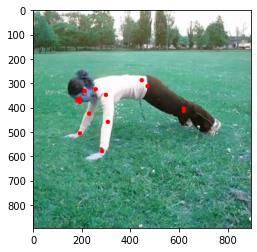

In [25]:
plt.imshow(orig_numpy)
plt.show()